# Defining Model Configuration

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2
import pandas as pd
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

IMG_SIZE = 128
BATCH_SIZE = 32
NUM_EPOCHS = 100
LEARN_RATE = 0.001

AGE_RANGES = [
    (0, 2),
    (3, 9),
    (10, 19),
    (20, 29),
    (30, 39),
    (40, 49),
    (50, 59),
    (60, 100)
]
NUM_CLASSES = len(AGE_RANGES)

def get_age_class(age):
    for idx, (min_age, max_age) in enumerate(AGE_RANGES):
        if min_age <= age <= max_age:
            return idx
    return len(AGE_RANGES) - 1

def preprocess_dataset(dataset_path, limit_samples=None):
    print("Loading and preprocessing dataset...")
    X = []
    y = []

    files = [f for f in os.listdir(dataset_path) if f.endswith('.jpg')]
    np.random.shuffle(files)

    if limit_samples:
        files = files[:limit_samples]

    for i, file in enumerate(files):
        if i % 1000 == 0:
            print(f"Processed {i} images")
        try:
            age = int(file.split('_')[0])

            if age > 100:
                continue

            img_path = os.path.join(dataset_path, file)
            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img = img / 255.0

            X.append(img)
            y.append(get_age_class(age))
        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
            continue

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)

    y = tf.keras.utils.to_categorical(y, num_classes=NUM_CLASSES)

    return X, y

def build_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(model.summary())
    return model

def create_data_generators(X_train, y_train, X_val, y_val):
    train_datagen = ImageDataGenerator(
        rotation_range=10,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator()

    # Create generators
    train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=BATCH_SIZE
    )

    val_generator = val_datagen.flow(
        X_val, y_val,
        batch_size=BATCH_SIZE
    )

    return train_generator, val_generator

def create_callbacks():
    os.makedirs('checkpoints', exist_ok=True)

    callbacks = [
        ModelCheckpoint(
            filepath='checkpoints/age_cnn_model_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),

        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),

        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-8,
            verbose=1
        )
    ]

    return callbacks

def train_model(model, train_generator, val_generator, steps_per_epoch, validation_steps):
    print("Starting model training...")

    callbacks = create_callbacks()

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=NUM_EPOCHS,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )

    return history

# Training

In [ ]:
dataset_path = "/content/UTKFace_Resized/UTKFace_Resized"

X, y = preprocess_dataset(dataset_path, limit_samples=None)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

train_generator, val_generator = create_data_generators(X_train, y_train, X_val, y_val)

steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE

model = build_cnn_model()

# Train model
history = train_model(model, train_generator, val_generator, steps_per_epoch, validation_steps)

# Save the final model
model.save('age_cnn_model_final.h5')
print("Model saved to 'age_cnn_model_final.h5'")

# Analyzing results

In [ ]:

from tensorflow.keras.models import load_model

def evaluate_model(model, X_test, y_test):
    print("Evaluating model performance...")

    # Get predictions
    y_pred_prob = model.predict(X_test, batch_size=BATCH_SIZE)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    print("Classification Report:")
    print(classification_report(
        y_true, y_pred,
        target_names=[f"{min_age}-{max_age}" for min_age, max_age in AGE_RANGES]
    ))
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=[f"{min_age}-{max_age}" for min_age, max_age in AGE_RANGES],
        yticklabels=[f"{min_age}-{max_age}" for min_age, max_age in AGE_RANGES]
    )
    plt.xlabel('Predição')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.close()

    # Plot training history
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()

def visualize_predictions(X_test, y_test, model, num_samples=10):
    print("Visualizing predictions...")

    indices = np.random.choice(range(len(X_test)), size=num_samples, replace=False)

    images = X_test[indices]
    true_labels = np.argmax(y_test[indices], axis=1)

    pred_probs = model.predict(images)
    pred_labels = np.argmax(pred_probs, axis=1)

    plt.figure(figsize=(20, 10))
    for i, (image, true_label, pred_label, pred_prob) in enumerate(zip(images, true_labels, pred_labels, pred_probs)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)

        true_range = f"{AGE_RANGES[true_label][0]}-{AGE_RANGES[true_label][1]}"
        pred_range = f"{AGE_RANGES[pred_label][0]}-{AGE_RANGES[pred_label][1]}"

        title = f"True: {true_range}\nPred: {pred_range} ({pred_prob[pred_label]:.2f})"
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    plt.close()

# Evaluate model
# model = build_cnn_model()
model = load_model("/content/age_cnn_model_final.h5")
evaluate_model(model, X_test, y_test)

visualize_predictions(X_test, y_test, model)

print("Process completed!")

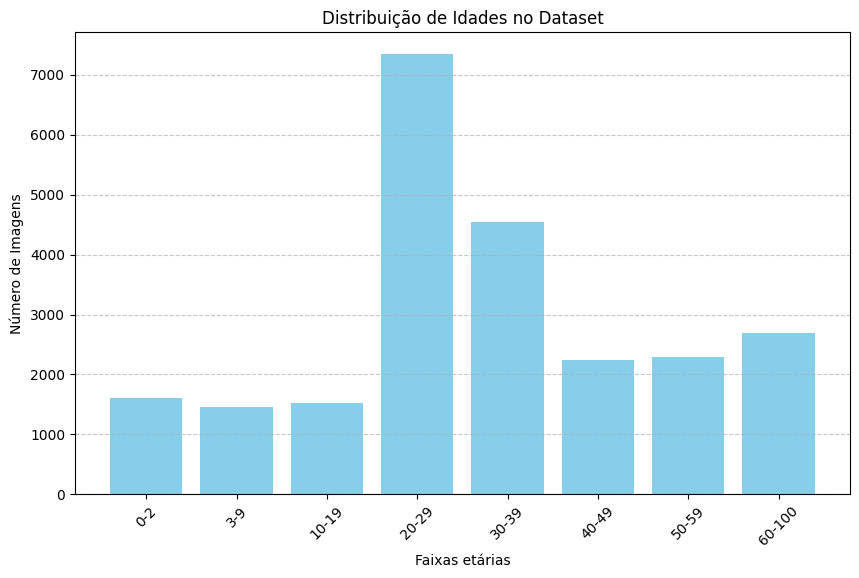

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Define age bins
age_bins = AGE_RANGES
bin_labels = [f"{low}-{high}" for low, high in age_bins]

# Function to get bin index
def get_bin_index(age):
    for i, (low, high) in enumerate(age_bins):
        if low <= age <= high:
            return i
    return len(age_bins) -1
  # Default to the last bin if age is out of bounds

# Function to parse ages from filenames
# Parse ages from filenames
def parse_ages_from_filenames(data_dir):
    ages = []
    for file in os.listdir(data_dir):
        if file.endswith(".jpg"):
            try:
                age = int(file.split('_')[0])  # Extract age from filename
                ages.append(age)
            except ValueError:
                print(f"Skipping invalid file: {file}")
    return ages

# Directory containing the dataset
data_dir = "/content/UTKFace_Resized/UTKFace_Resized"

# Analyze age distribution
ages = parse_ages_from_filenames(data_dir)
bin_counts = [0] * (len(age_bins))  # Initialize counts for each bin
for age in ages:
    bin_index = get_bin_index(age)
    bin_counts[bin_index] += 1

# Plot the age distribution
plt.figure(figsize=(10, 6))
plt.bar(bin_labels, bin_counts, color='skyblue')
plt.xlabel("Faixas etárias")
plt.ylabel("Número de Imagens")
plt.title("Distribuição de Idades no Dataset")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Helper to unzip files

In [ ]:
# Extract zip file
import zipfile
import os

zip_file_name = "/content/UTKFace_Resized.zip"
dataset_folder = "/content/UTKFace_Resized"

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(dataset_folder)

# Verify extraction
print("Files extracted to:", dataset_folder)
print("Sample files:", os.listdir(dataset_folder)[:10])

Files extracted to: /content/UTKFace_Resized
Sample files: ['UTKFace_Resized']
